<a href="https://colab.research.google.com/github/Clarens/TWOH-Story-Prototyp/blob/main/color_calib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install OpenEXR Imath
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.3 MB/s eta 0:00:00


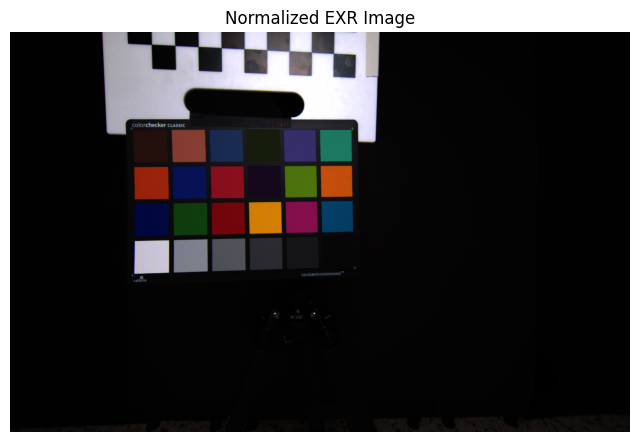

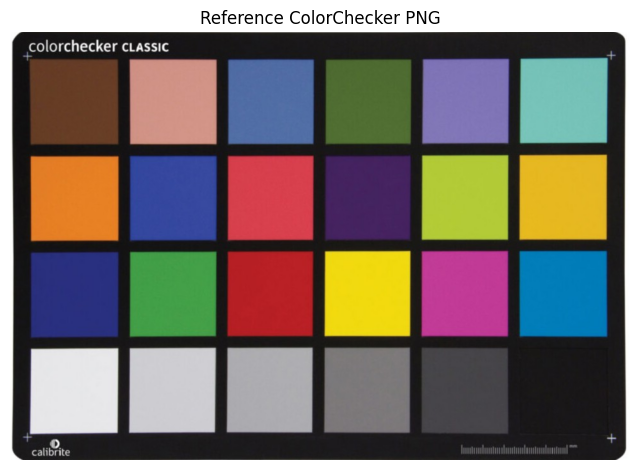

Scale 0.50: max_score = 0.3505 at (768, 776)
Scale 0.60: max_score = 0.4062 at (734, 742)
Scale 0.70: max_score = 0.3378 at (771, 609)
Scale 0.80: max_score = 0.3396 at (604, 616)
Scale 0.90: max_score = 0.3673 at (587, 525)
Scale 1.00: max_score = 0.4667 at (600, 473)
Scale 1.10: max_score = 0.7023 at (560, 416)
Scale 1.20: max_score = 0.4720 at (532, 379)
Scale 1.30: max_score = 0.2975 at (514, 323)
Scale 1.40: max_score = 0.2252 at (392, 274)
Scale 1.50: max_score = 0.1512 at (300, 270)
Scale 1.60: max_score = 0.1779 at (221, 129)
Scale 1.70: max_score = 0.1715 at (187, 115)
Scale 1.80: max_score = 0.1455 at (106, 84)
Scale 1.90: max_score = 0.1195 at (54, 0)
Scale 2.00: max_score = 0.0903 at (10, 0)
Best match: Scale = 1.10, Score = 0.7023, Location = (560, 416)
Detected ColorChecker area: Top-Left = (560, 416), Bottom-Right = (1628, 1154)


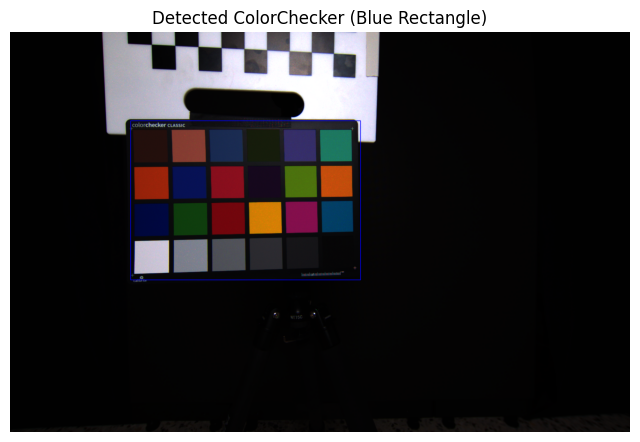

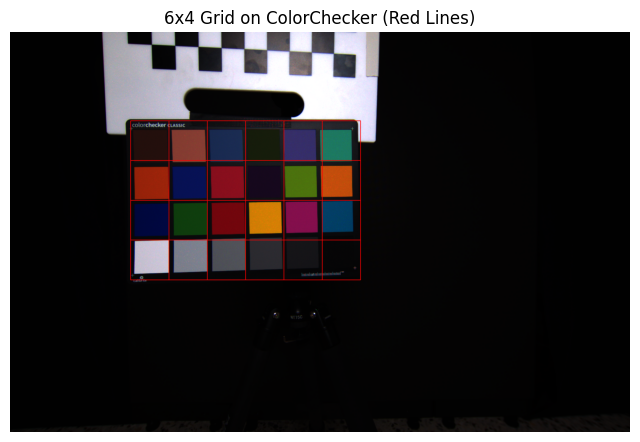

Measured Lab Values:
[[  6.7320557    9.553594     4.69      ]
 [ 35.17279     30.011875    21.65625   ]
 [ 18.38623      7.168125   -25.725     ]
 [  9.5633545   -6.753281     9.112968  ]
 [ 22.865845    20.429531   -33.541874  ]
 [ 45.362305   -32.070625     5.0440626 ]
 [ 34.03424     47.21875     42.773438  ]
 [ 10.152222    24.266718   -40.967342  ]
 [ 28.663269    48.253906    26.890469  ]
 [  4.1504517    9.077188    -9.735469  ]
 [ 43.893623   -28.80922     45.675156  ]
 [ 48.31518     44.562813    55.427032  ]
 [  4.8116455   19.632656   -34.871407  ]
 [ 22.190796   -26.82328     24.219376  ]
 [ 22.688599    42.888283    28.554531  ]
 [ 61.135307    25.655       66.66484   ]
 [ 29.277893    51.075783    -4.6029687 ]
 [ 24.944153    -1.6114062  -27.014843  ]
 [ 79.79737      4.5429688   -7.988125  ]
 [ 54.20899      0.6575      -5.9259377 ]
 [ 34.416626     1.6582812   -4.164375  ]
 [ 17.53424      2.0825      -3.4478126 ]
 [  6.96875      0.7060937   -1.5507812 ]
 [  1.7215576

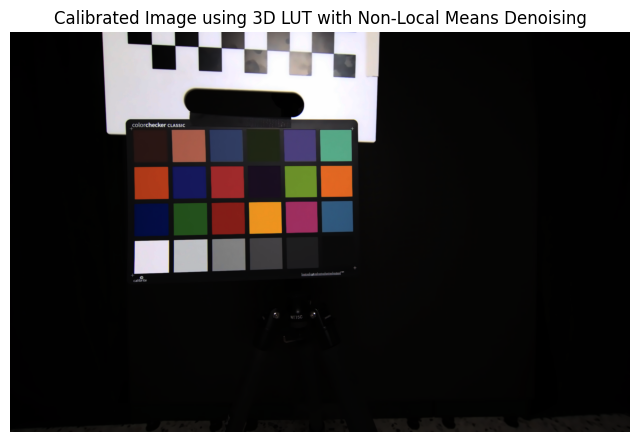

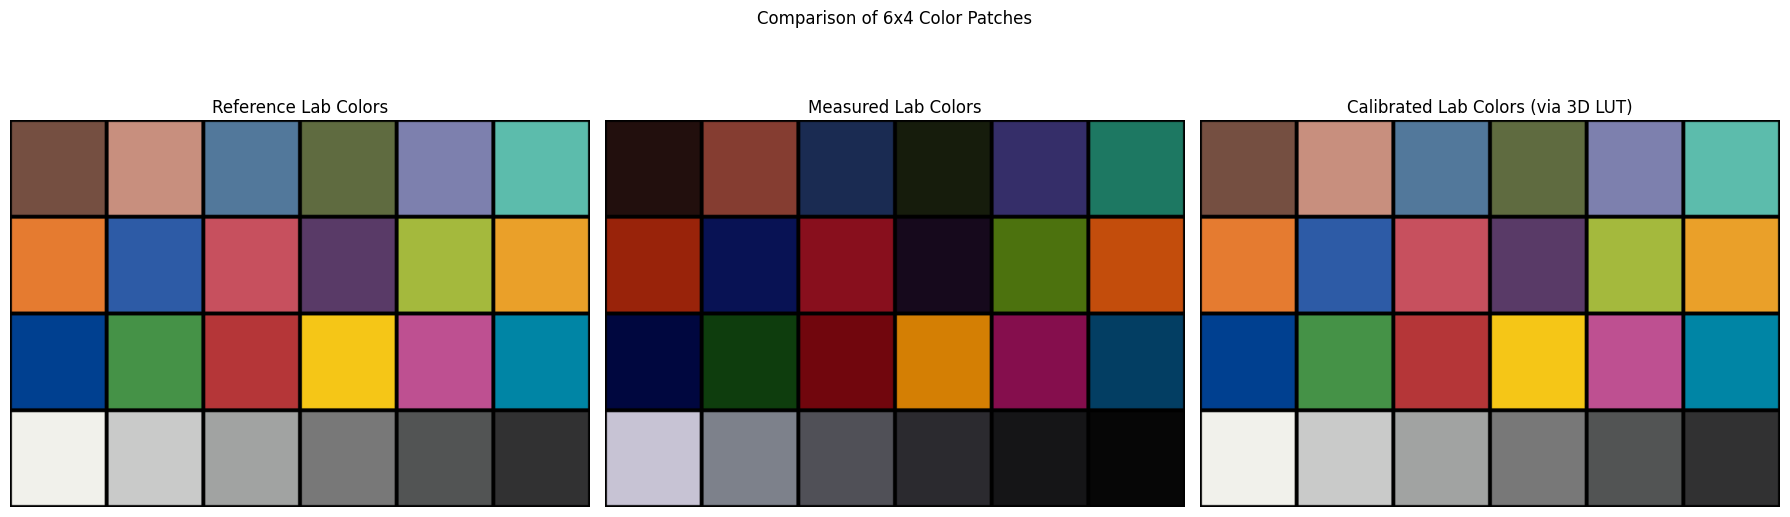

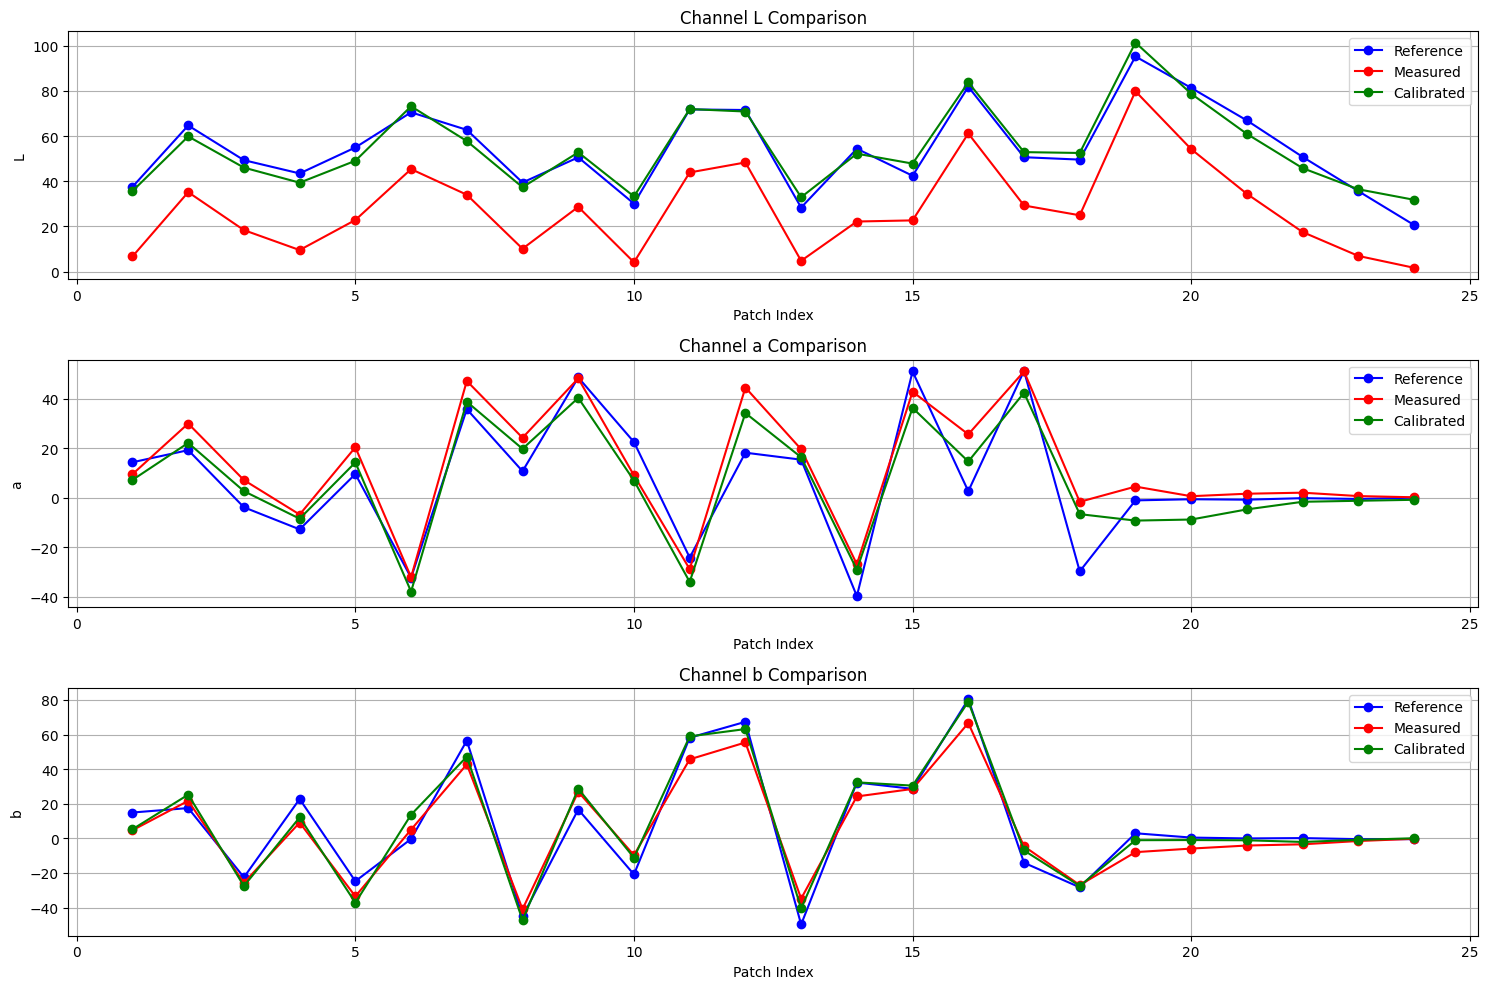

In [8]:
import OpenEXR, Imath
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator, RegularGridInterpolator

# =============================================================================
# Hilfsfunktionen
# =============================================================================

def show_image(img, title="Image", cmap=None):
    # Falls img als float32 vorliegt (Werte in [0,1]), für die Anzeige in uint8 konvertieren
    if img.dtype in [np.float32, np.float64]:
        if img.max() <= 1.0:
            img_disp = (img * 255).astype(np.uint8)
        else:
            img_disp = img.astype(np.uint8)
    else:
        img_disp = img
    plt.figure(figsize=(8,8))
    if len(img_disp.shape) == 2:
        plt.imshow(img_disp, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def read_exr_image(file_path):
    exr_file = OpenEXR.InputFile(file_path)
    header = exr_file.header()
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    if all(c in header['channels'] for c in ['R','G','B']):
        r = np.frombuffer(exr_file.channel('R', pt), dtype=np.float32).reshape((height, width))
        g = np.frombuffer(exr_file.channel('G', pt), dtype=np.float32).reshape((height, width))
        b = np.frombuffer(exr_file.channel('B', pt), dtype=np.float32).reshape((height, width))
        # OpenCV arbeitet mit BGR
        image = np.dstack((b, g, r))
        return image.astype(np.float32)
    else:
        raise ValueError("EXR file is missing one of the channels R, G, B.")

def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    norm_img = (image - min_val) / (max_val - min_val)
    norm_img = norm_img.astype(np.float32)
    return norm_img, np.float32(min_val), np.float32(max_val)

def multi_scale_template_match(norm_gray, ref_gray, scales=np.linspace(0.5, 2.0, num=16, dtype=np.float32)):
    best_score = -np.inf
    best_scale = None
    best_loc = None
    best_template = None
    for scale in scales:
        resized_ref = cv2.resize(ref_gray, (0, 0), fx=float(scale), fy=float(scale))
        if resized_ref.shape[0] > norm_gray.shape[0] or resized_ref.shape[1] > norm_gray.shape[1]:
            continue
        result = cv2.matchTemplate(norm_gray, resized_ref, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        print(f"Scale {scale:.2f}: max_score = {max_val:.4f} at {max_loc}")
        if max_val > best_score:
            best_score = max_val
            best_scale = scale
            best_loc = max_loc
            best_template = resized_ref
    return best_score, best_scale, best_loc, best_template

def measure_color_patches(lab_image, top_left, cell_width, cell_height, num_rows=4, num_cols=6, patch_size=10):
    measured_lab = []
    centers = []
    patch_radius = patch_size // 2
    for row in range(num_rows):
        for col in range(num_cols):
            cell_tl = (int(top_left[0] + col * cell_width), int(top_left[1] + row * cell_height))
            cell_br = (int(top_left[0] + (col+1) * cell_width), int(top_left[1] + (row+1) * cell_height))
            cx = (cell_tl[0] + cell_br[0]) // 2
            cy = (cell_tl[1] + cell_br[1]) // 2
            centers.append((cx, cy))
            patch = lab_image[max(cy-patch_radius, 0):min(cy+patch_radius, lab_image.shape[0]),
                              max(cx-patch_radius, 0):min(cx+patch_radius, lab_image.shape[1]), :]
            mean_lab = np.mean(patch.reshape(-1, 3), axis=0)
            measured_lab.append(mean_lab)
    return np.array(measured_lab, dtype=np.float32), centers

def lab_to_bgr(lab):
    lab_img = np.array([[lab]], dtype=np.float32)
    bgr_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
    bgr_img = np.clip(bgr_img, 0, 1)
    return (bgr_img[0,0] * 255).astype(np.uint8)

def draw_lab_grid(lab_values, rows=4, cols=6, cell_size=50):
    grid_img = np.zeros((rows*cell_size, cols*cell_size, 3), dtype=np.uint8)
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            color_bgr = lab_to_bgr(lab_values[idx])
            grid_img[r*cell_size:(r+1)*cell_size, c*cell_size:(c+1)*cell_size] = color_bgr
            cv2.rectangle(grid_img, (c*cell_size, r*cell_size), ((c+1)*cell_size-1, (r+1)*cell_size-1), (0,0,0), 1)
    return grid_img

def calibrate_colors(measured_lab, ref_lab):
    ones = np.ones((measured_lab.shape[0], 1), dtype=np.float32)
    measured_aug = np.hstack([measured_lab, ones])
    X, residuals, rank, s = np.linalg.lstsq(measured_aug, ref_lab, rcond=None)
    X = X.astype(np.float32)
    calibrated_lab = (measured_aug.dot(X)).astype(np.float32)
    return X, calibrated_lab

# =============================================================================
# 3D LUT Erzeugung aus Kalibrierungspunkten (lineare Interpolation, z.B. 3x3x3)
# =============================================================================

def create_3d_lut(measured_lab, ref_lab, lut_size=(3,3,3)):
    interp_model = LinearNDInterpolator(measured_lab, ref_lab)
    L_vals = np.linspace(0, 100, lut_size[0], dtype=np.float32)
    a_vals = np.linspace(-128, 127, lut_size[1], dtype=np.float32)
    b_vals = np.linspace(-128, 127, lut_size[2], dtype=np.float32)
    L_grid, a_grid, b_grid = np.meshgrid(L_vals, a_vals, b_vals, indexing='ij')
    grid_points = np.vstack([L_grid.ravel(), a_grid.ravel(), b_grid.ravel()]).T.astype(np.float32)
    corrected = interp_model(grid_points)
    nan_mask = np.isnan(corrected[:,0])
    corrected[nan_mask] = grid_points[nan_mask]
    lut = corrected.reshape(lut_size[0], lut_size[1], lut_size[2], 3).astype(np.float32)
    return L_vals, a_vals, b_vals, lut

def apply_3d_lut(lab_image, L_vals, a_vals, b_vals, lut):
    interp_lut = RegularGridInterpolator((L_vals, a_vals, b_vals), lut, bounds_error=False, fill_value=None)
    H, W, _ = lab_image.shape
    lab_flat = lab_image.reshape(-1, 3)
    calibrated_flat = interp_lut(lab_flat).astype(np.float32)
    calibrated_image = calibrated_flat.reshape(H, W, 3)
    return calibrated_image

# =============================================================================
# Hauptpipeline
# =============================================================================

# 1. EXR-Bild einlesen und normalisieren (alle Berechnungen in float32)
exr_path = '/content/drive/MyDrive/HDR_EXR/hdr_bild06.exr'
image_exr = read_exr_image(exr_path)
norm_img, min_val, max_val = normalize_image(image_exr)
show_image(norm_img, "Normalized EXR Image")

# 2. Referenz-ColorChecker PNG laden und in float32 konvertieren
ref_path = '/content/drive/MyDrive/HDR_EXR/ref_colorchecker.png'
ref_img = cv2.imread(ref_path)
if ref_img is None:
    raise ValueError("Reference ColorChecker PNG not found!")
ref_img = ref_img.astype(np.float32) / 255.0
show_image(ref_img, "Reference ColorChecker PNG")

# 3. Multi-Scale Template Matching zur Lokalisierung des ColorCheckers
# Konvertiere zu Grau in float32
norm_gray = cv2.cvtColor(norm_img, cv2.COLOR_BGR2GRAY).astype(np.float32)
ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY).astype(np.float32)
best_score, best_scale, best_loc, best_template = multi_scale_template_match(norm_gray, ref_gray)
print(f"Best match: Scale = {best_scale:.2f}, Score = {best_score:.4f}, Location = {best_loc}")
template_h, template_w = best_template.shape[:2]
top_left = best_loc
bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
print(f"Detected ColorChecker area: Top-Left = {top_left}, Bottom-Right = {bottom_right}")
detected_img = norm_img.copy()
cv2.rectangle(detected_img, top_left, bottom_right, (1.0, 0, 0), 2)  # Farbe in float32 (BGR: (1,0,0))
show_image(detected_img, "Detected ColorChecker (Blue Rectangle)")

# 4. Erstelle ein 6x4 Raster im detektierten Bereich
num_cols, num_rows = 6, 4
cell_width = template_w / num_cols
cell_height = template_h / num_rows
grid_img = detected_img.copy()
for i in range(1, num_cols):
    x = int(top_left[0] + i * cell_width)
    cv2.line(grid_img, (x, top_left[1]), (x, bottom_right[1]), (0, 0, 1.0), 2)
for j in range(1, num_rows):
    y = int(top_left[1] + j * cell_height)
    cv2.line(grid_img, (top_left[0], y), (bottom_right[0], y), (0, 0, 1.0), 2)
cv2.rectangle(grid_img, top_left, bottom_right, (0, 0, 1.0), 2)
show_image(grid_img, "6x4 Grid on ColorChecker (Red Lines)")

# 5. Farbwerte messen: 10x10 Patch in der Mitte jeder Zelle im CIELab-Farbraum
lab_image = cv2.cvtColor(norm_img, cv2.COLOR_BGR2LAB).astype(np.float32)  # L in [0,100], a,b ca. [-128,127]
measured_lab, patch_centers = measure_color_patches(lab_image, top_left, cell_width, cell_height, num_rows, num_cols, patch_size=10)
print("Measured Lab Values:")
print(measured_lab)

# 6. Referenzwerte (bekannte ColorChecker Lab-Werte) in float32
ref_values_raw = [
    [37.54, 14.37, 14.92],
    [62.73, 35.83, 56.5],
    [28.37, 15.42, -49.8],
    [95.19, -1.03, 2.93],
    [64.66, 19.27, 17.5],
    [39.43, 10.75, -45.17],
    [54.38, -39.72, 32.27],
    [81.29, -0.57, 0.44],
    [49.32, -3.82, -22.54],
    [50.57, 48.64, 16.67],
    [42.43, 51.05, 28.62],
    [66.89, -0.75, -0.06],
    [43.46, -12.74, 22.72],
    [30.10, 22.54, -20.87],
    [81.80, 2.67, 80.41],
    [50.76, -0.13, 0.14],
    [54.94, 9.61, -24.79],
    [71.77, -24.13, 58.19],
    [50.63, 51.28, -14.12],
    [35.63, -0.46, -0.48],
    [70.48, -32.26, -0.37],
    [71.51, 18.24, 67.37],
    [49.57, -29.71, -28.32],
    [20.64, 0.07, -0.46]
]
ref_values = np.array(ref_values_raw, dtype=np.float32)
ref_values = ref_values.reshape(6, 4, 3).transpose(1, 0, 2).reshape(24, 3)
print("Reference Lab Values:")
print(ref_values)

# 7. Erzeuge 3D LUT basierend auf den Kalibrierungspunkten (z.B. 3x3x3)
L_vals, a_vals, b_vals, lut = create_3d_lut(measured_lab, ref_values, lut_size=(3,3,3))
print("3D LUT created with shape:", lut.shape)

# 8. Wende 3D LUT auf das gesamte Bild im Lab-Farbraum an
calibrated_lab_image = apply_3d_lut(lab_image, L_vals, a_vals, b_vals, lut)
calibrated_bgr = cv2.cvtColor(calibrated_lab_image, cv2.COLOR_LAB2BGR)
calibrated_bgr = np.clip(calibrated_bgr, 0, 1).astype(np.float32)

# Speichere das finale kalibrierte EXR Bild (als float32)
H, W, _ = calibrated_bgr.shape
header = OpenEXR.Header(W, H)
pt = Imath.PixelType(Imath.PixelType.FLOAT)
header['channels'] = {"R": Imath.Channel(pt), "G": Imath.Channel(pt), "B": Imath.Channel(pt)}
exr_out = OpenEXR.OutputFile("calibrated_final.exr", header)
R_channel = calibrated_bgr[:, :, 2].astype(np.float32).tobytes()
G_channel = calibrated_bgr[:, :, 1].astype(np.float32).tobytes()
B_channel = calibrated_bgr[:, :, 0].astype(np.float32).tobytes()
exr_out.writePixels({"R": R_channel, "G": G_channel, "B": B_channel})
exr_out.close()
print("Final calibrated EXR image saved as 'calibrated_final.exr'.")

# Wende Non-Local Means Denoising an, um Rauschen zu reduzieren (für Anzeige erfolgt die Konvertierung in uint8)
calibrated_bgr_uint8 = (calibrated_bgr * 255).astype(np.uint8)
denoised = cv2.fastNlMeansDenoisingColored(calibrated_bgr_uint8, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
cv2.imwrite("calibrated_image_denoised.png", denoised)
show_image(denoised, "Calibrated Image using 3D LUT with Non-Local Means Denoising")

# 9. Visualisierung der Farbwerte als farbige 6x4 Raster
cell_size = 50
ref_grid = draw_lab_grid(ref_values, rows=num_rows, cols=num_cols, cell_size=cell_size)
measured_grid = draw_lab_grid(measured_lab, rows=num_rows, cols=num_cols, cell_size=cell_size)
# Verwende ein einfaches Modell, um die kalibrierten Patch-Werte zu berechnen
interp_model = LinearNDInterpolator(measured_lab, ref_values)
calibrated_patches = interp_model(measured_lab)
nan_mask = np.isnan(calibrated_patches[:, 0])
calibrated_patches[nan_mask] = measured_lab[nan_mask]
calibrated_grid = draw_lab_grid(calibrated_patches, rows=num_rows, cols=num_cols, cell_size=cell_size)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(ref_grid, cv2.COLOR_BGR2RGB))
plt.title("Reference Lab Colors")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(measured_grid, cv2.COLOR_BGR2RGB))
plt.title("Measured Lab Colors")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(calibrated_grid, cv2.COLOR_BGR2RGB))
plt.title("Calibrated Lab Colors (via 3D LUT)")
plt.axis("off")

plt.suptitle("Comparison of 6x4 Color Patches")
plt.tight_layout()
plt.show()

# =============================================================================
# Zusätzlich: Diagramm mit Referenz, Messwert und kalibrierten Werten
# =============================================================================

X, calibrated_lab = calibrate_colors(measured_lab, ref_values)
patch_indices = np.arange(1, 25)

plt.figure(figsize=(15, 10))
channels = ['L', 'a', 'b']
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(patch_indices, ref_values[:, i], 'bo-', label='Reference')
    plt.plot(patch_indices, measured_lab[:, i], 'ro-', label='Measured')
    plt.plot(patch_indices, calibrated_lab[:, i], 'go-', label='Calibrated')
    plt.title(f"Channel {channels[i]} Comparison")
    plt.xlabel("Patch Index")
    plt.ylabel(channels[i])
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()
